In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [2]:
river_dl = np.load("../../../Downloads/prepped2.npz", allow_pickle = True)

x = torch.from_numpy(river_dl['x_trn']).float()[-455:] # use the last year of data for all 455 segments
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:]

# maintains relationships, just changes how they're organized
reorder_spatially = np.random.choice(455, 455, replace=False)

adj_matrix = river_dl['dist_matrix']
batch_size = adj_matrix.shape[0]

x.shape, y.shape, adj_matrix.shape

(torch.Size([455, 365, 16]), torch.Size([455, 365, 1]), (455, 455))

# Define RGCN v1

In [3]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out
        
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

In [4]:
model = RGCN_v1(16, 20, adj_matrix)

In [5]:
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters())

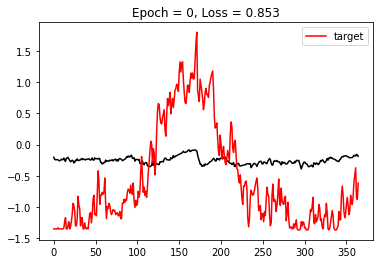

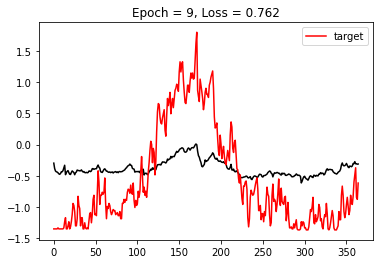

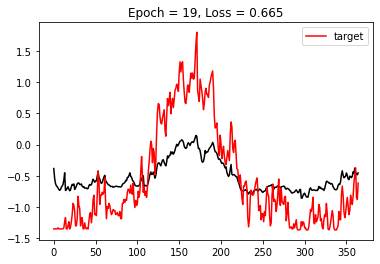

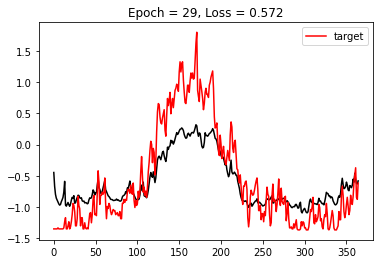

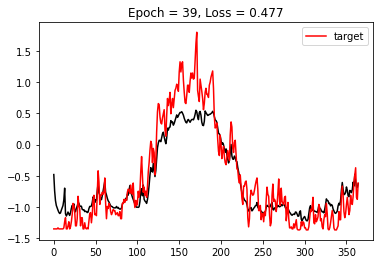

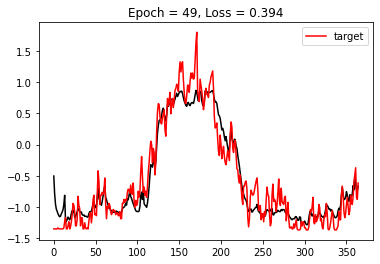

In [6]:
epochs = 50

for i in range(epochs):
    out = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % int(epochs/5) == 0 or i == 0:
        plt.plot(out.detach()[1], color = 'black')
        plt.plot(y[1], color = 'red', label = 'target')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.pause(0.001);

# Define a manual/custom implementation of Integrated Gradients

In [7]:
def integrated_gradients(x, y, model, n_steps, baseline_x, temporal_focus=None, spatial_focus=None):
    x.requires_grad = True
    x_diff = x - baseline_x

    for k in range(1, n_steps):
        numerator_scale = k/n_steps
        curr_x = baseline_x + numerator_scale*x_diff
        y = model(curr_x)
        if temporal_focus == None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
        elif temporal_focus == None and spatial_focus != None:
            gradients = torch.autograd.grad(y[spatial_focus, :, :], curr_x, torch.ones_like(y[spatial_focus, :, :]))
        elif temporal_focus != None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
        else:
            gradients = torch.autograd.grad(y[spatial_focus, temporal_focus, :], curr_x, torch.ones_like(y[spatial_focus, temporal_focus, :]))
            
        if k == 1:
            integrated_gradients = gradients
        else:
            integrated_gradients = integrated_gradients + gradients

    integrated_gradients = x_diff.detach().numpy()*integrated_gradients[0].detach().numpy()
    return(integrated_gradients)

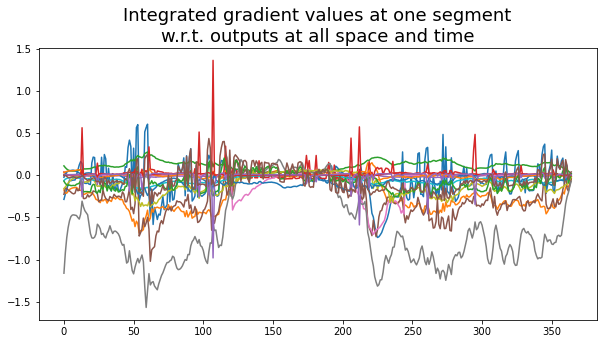

In [8]:
IG_vals = integrated_gradients(x, y, model, 2, torch.zeros_like(x))

plt.figure(figsize = (10, 5))
for i in range(16):
    plt.plot(IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

# Exploring different autograd grad_tensors()

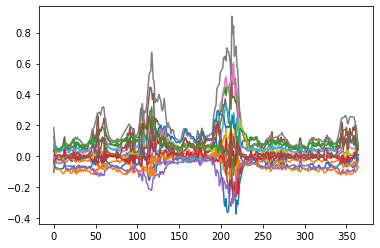

In [9]:
y = model(x)
model.zero_grad()
grad = torch.autograd.grad(y, x, torch.ones_like(y))
plt.plot(grad[0][0]);

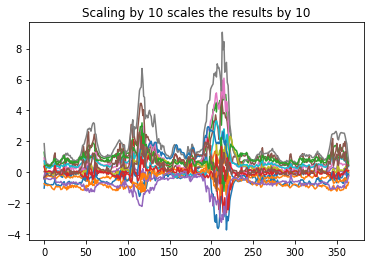

In [10]:
y = model(x)
grad = torch.autograd.grad(y, x, 10*torch.ones_like(y))
plt.plot(grad[0][0])
plt.title('Scaling by 10 scales the results by 10');

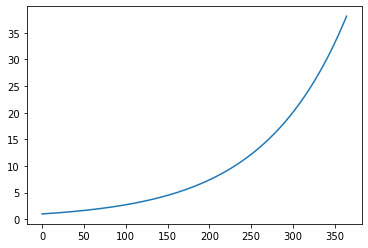

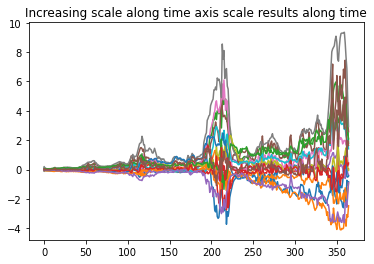

In [11]:
scale_vals = torch.exp(torch.arange(365)/100)
scale_vals = torch.ones(455, 365) * scale_vals
grad_tensor = scale_vals.unsqueeze(2)
plt.plot(grad_tensor[0])
plt.pause(0.01)

y = model(x)
grad = torch.autograd.grad(y, x, grad_tensor)
plt.plot(grad[0][0])
plt.title('Increasing scale along time axis scale results along time');

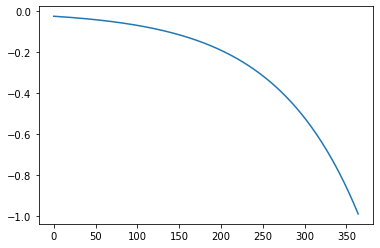

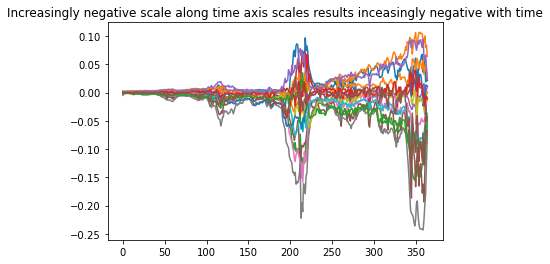

In [12]:
scale_vals = -1*torch.exp(torch.arange(-365, 0)/100)
scale_vals = torch.ones(455, 365) * scale_vals
grad_tensor = scale_vals.unsqueeze(2)
plt.plot(grad_tensor[0])
plt.pause(0.01)

y = model(x)
grad = torch.autograd.grad(y, x, grad_tensor)
plt.plot(grad[0][0])
plt.title('Increasingly negative scale along time axis scales results inceasingly negative with time');

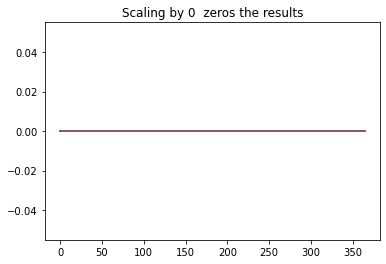

In [13]:
y = model(x)
grad = torch.autograd.grad(y, x, torch.zeros_like(y))
plt.plot(grad[0][0])
plt.title('Scaling by 0  zeros the results');